## Part 2: Descriptor Calculations and Exploratory Data Analysis
## Load Data

In [21]:
conda install -c conda-forge rdkit

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.70.0               |   py38hbf1eeb5_1         347 KB  conda-forge
    boost-cpp-1.70.0           |       hd59e818_1        19.0 MB  conda-forge
    cairo-1.16.0               |    h0ab9d94_1001         1.3 MB  conda-forge
    conda-4.9.0                |   py38h5347e94_1         3.0 MB  conda-forge
    fontconfig-2.13.1          |    h1027ab8

In [3]:
import pandas as pd
df = pd.read_csv('acetylcholinesterase_bioactivity_data_curated.csv')
df_no_smiles = df.drop(columns='canonical_smiles')
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
4690,CHEMBL4293155,2440.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...
4691,CHEMBL4282558,2540.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...
4692,CHEMBL4281727,3810.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...
4693,CHEMBL4292349,3460.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...


## Calculate Lipinski descriptors
Christopher Lipinski from Pfizer came up with a back of the envelope method for evaluating the druglikeness of compounds. Druglikeness is based on Absorption, Distribution, Metabolism, and Excretion (ADME) - pharmokinetic profile. Based on FDA approved orally adminstered drugs.

Tells us the relative drug-likeness of the compound: whether it can be absorbed into th ebody, distributed to the proper tissues, become metabloized, and eventually be excreted (global features of the molecules)

### Lipinski Rule
    Molecular Weight < 500 Daltons
    Octanol-water partition coefficient (LogP) < 5
    Hydrogen bond donors < 5
    Hydrogen bond acceptors < 10

In [23]:
#Import Libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [24]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [25]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
4690,511.150,7.07230,2.0,3.0
4691,511.150,7.07230,2.0,3.0
4692,555.601,7.18140,2.0,3.0
4693,521.702,6.32710,2.0,5.0


In [26]:
#Combine standard value with lipinksi descriptors
df_combined = pd.concat([df,df_lipinski], axis=1) 
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate,511.150,7.07230,2.0,3.0
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate,511.150,7.07230,2.0,3.0
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate,555.601,7.18140,2.0,3.0
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate,521.702,6.32710,2.0,5.0


## IC50 to pIC50 = -log(IC50)
Function to

    Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10^-9
    
    Take the molar value and apply -log10
    
    Delete the standard_value column and create a new pIC50 column

In [27]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [28]:
df_combined.standard_value.describe()

count    4.695000e+03
mean     3.210931e+12
std      1.189580e+14
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

In [29]:
#Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [30]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,2440.0
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,2540.0
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,3810.0
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,3460.0


In [31]:
df_norm.standard_value_norm.describe()

count    4.695000e+03
mean     3.276494e+05
std      4.718369e+06
min      6.000000e-03
25%      1.250000e+02
50%      2.246000e+03
75%      1.753000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [32]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,intermediate,511.150,7.07230,2.0,3.0,5.612610
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,intermediate,511.150,7.07230,2.0,3.0,5.595166
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,intermediate,555.601,7.18140,2.0,3.0,5.419075
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,intermediate,521.702,6.32710,2.0,5.0,5.460924


In [33]:
df_final.pIC50.describe()

count    4695.000000
mean        5.820864
std         1.552813
min         1.000000
25%         4.756219
50%         5.648590
75%         6.903090
max        11.221849
Name: pIC50, dtype: float64

In [34]:
df_final.to_csv('acetylcholinesterase_bioactivity_data_pIC50.csv')

## Removing Intermediates

In [35]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4675,CHEMBL4284261,CCN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,180.251,1.4261,2.0,3.0,3.015428
4676,CHEMBL4276921,CN(C)Cc1cc(N)ccc1O.Cl.Cl,inactive,166.224,1.0360,2.0,3.0,2.813467
4677,CHEMBL4292574,CNCc1cc(N)ccc1O.Cl.Cl,inactive,152.197,0.6938,3.0,3.0,3.476904
4685,CHEMBL4292766,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3F)CC2...,active,494.695,6.5580,2.0,3.0,6.124939


In [36]:
df_2class.to_csv('acetylcholinesterase_bioactivity_no_intermediates_pIC50.csv')

## Exploratory Data Analysis (Chemical Space Analysis) with Lipinksi Descriptors

In [37]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

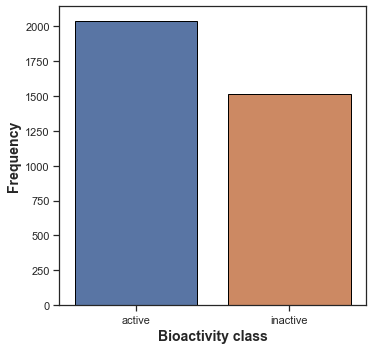

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Both bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP

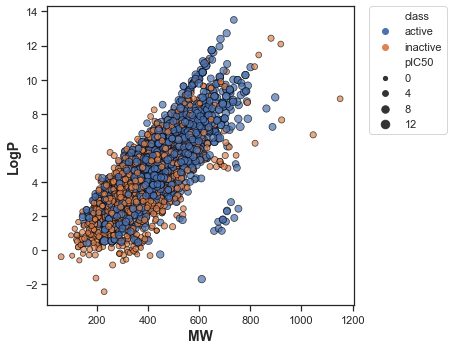

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### Boxplots
### pIC50 Plot

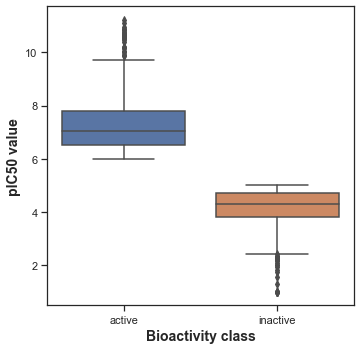

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### Statistical analysis | Mann-Whitney U Test

In [43]:
def mannwhitney(descriptor, verbose=False):
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [44]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


### MW

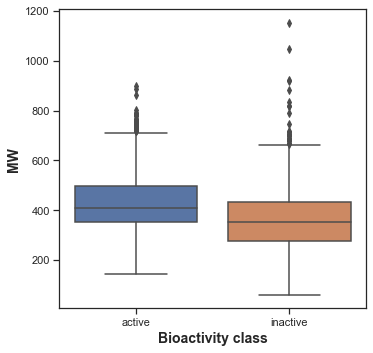

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [47]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1058779.0,2.072256e-57,0.05,Different distribution (reject H0)


### Log P

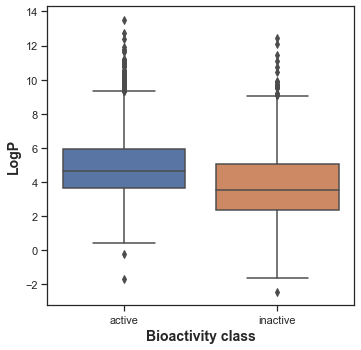

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [49]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1041929.0,2.355826e-61,0.05,Different distribution (reject H0)


### Num H Donors

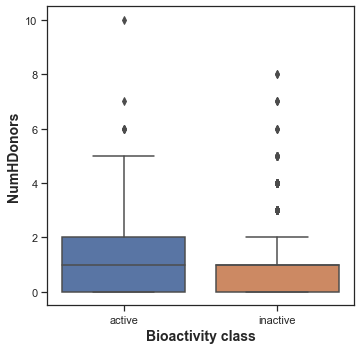

In [50]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [51]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1361005.5,2.520096e-10,0.05,Different distribution (reject H0)


### Num of H Acceptors

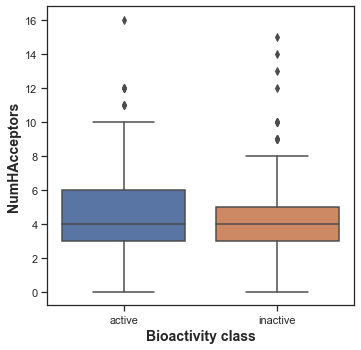

In [52]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [53]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1407547.5,0.000004,0.05,Different distribution (reject H0)


## Interpretation of Statistics
Box Plots

pIC50 values
Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

Lipinski's descriptors

All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives.

In [55]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: acetylcholinesterase_bioactivity_data_pIC50.csv (deflated 76%)
  adding: acetylcholinesterase_bioactivity_no_intermediates_pIC50.csv (deflated 76%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: mannwhitneyu_MW.csv (deflated 10%)
  adding: plot_bioactivity_class.pdf (deflated 39%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 38%)
  adding: acetylcholinesterase_bioactivity_data_curated.csv (deflated 82%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: acetylcholinesterase_bioactivity_data_preprocessed.csv (deflated 81%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: mannwhitneyu_pIC50.csv (deflated 14%)
  adding: acetylcholinesterase_bioactivity_data_raw.csv (deflated 90%)
  adding: plot_MW_vs_LogP.pdf (deflated 2%)
  adding: mannwhitneyu_LogP.csv (deflated 10%)
